<html id="** データフィッティング">
	<author>Hiroshi TAKEMOTO</author>
	(<email>take.pwave@gmail.com</email>)
	
	<h2>データフィッティング</h2>
	<p>
		与えられたデータに最もよくフィットする関数を求めるのが、「データフィッティング」です。
		今回は、$ sin(2 \pi x) $曲線に正規分布のノイズを加えたテストデータを３次多項式で
		近似しながら、Sageでのデータフィッティングの方法と手法のもつ問題点について説明します。
	</p>
	
</html>

<html id="** テストデータの生成">
	<h3>テストデータの生成</h3>
	<p>
		テストデータは、区間[0, 1]でランダムに抽出したxに対して、以下の式で与えられるyを計算して生成します。
$$ 
		y = sin(2 \pi x) + \mathcal{N}(0,0.3) 
$$
	</p>
	<p>
		変数X, Yにそれぞれ１０個のx座標、y座標のリストをセットします。
		このままで計算するたびにX, Yの値が異なってしまうので、一度作成した値をsave関数でワークシートに保存し、
		load関数で読み込んでいます。
	</p>
</html>

In [1]:
# テストデータ生成
#X = [random() for i in range (10)]
#Y = [sin(2*pi*x) + gauss(0, 0.3) for x in X]
# データの保存
#save(X, 'data/X')
#save(Y, data/Y')
# データのリストア
X = load('data/X')
Y = load('data/Y')

<html>
	<p>
		生成されたデータをもとの$ sin(2 \pi x) $曲線と一緒にプロットしてみます。
		後で、少ないデータでのフィッティングに使うため、最初の３点の座標は赤で、
		残りを青でプロットしています。
	</p>
</html>

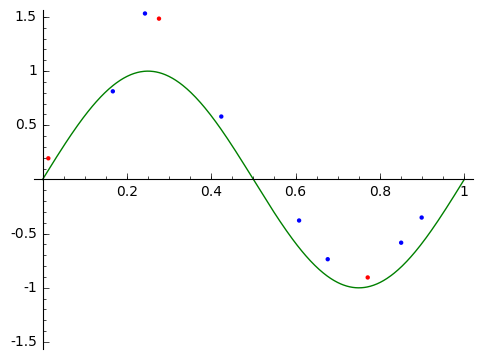

In [2]:
# データのプロット
x = var('x')
sin_plt = plot(sin(2*pi*x),[x, 0, 1], rgbcolor='green')
blue_plt = list_plot(zip(X[3:], Y[3:]))
red_plt = list_plot(zip(X[:3], Y[:3]), rgbcolor='red')
data_plt = list_plot(zip(X, Y));
(blue_plt + red_plt + sin_plt).show(xmin=0, xmax= 1, ymin=-1.5, ymax=1.5, figsize=5)

<html>
	<h2>フィッティング関数</h2>
	<p>
		Sageが提供している曲線のフィッティング関数がfind_fit関数です。find_fit関数の使い方を以下に示します。
		<pre>
find_fit(データ, モデル, オプション)			
		</pre>		
		データには、モデルで使用する変数の値（ここではx）リストと観測地（ここではy）の組（タプルまたはリスト）の
		リストを渡し、モデルには変数を与えると予測値を計算するモデルの関数を渡します。
	</p>
	<p>
		今回の例では、modelとして、以下の３次多項式を使用します。
$$
		model(x) = w_0 + w_1 x + w_2 x^2 + w_3 x^3
$$		
	</p>
	<p>
		find_fitで求められた$w_0, w_1, w_2, w_3$を使って関数f_fitを定義するには、
		辞書型で結果をもらうと便利です。solution_dict=Trueオプションを指定すると計算結果が
		辞書型で返されます。
	</p>
</html>

In [3]:
(w0, w1, w2, w3) = var('w0 w1 w2 w3')
model(x) = w0 + w1*x + w2*x^2 + w3*x^3
data = zip(X, Y)
fit = find_fit(data, model, solution_dict=True)
show(fit)

{w0: -0.08791180900984033,
 w1: 14.092259606071723,
 w2: -40.87357306897882,
 w3: 27.67067970115225}

<html>
	<h3>フィッティング曲線のプロット</h3>
	<p>
		モデルmodelにfind_fitの結果fitを代入して、フィッティング曲線の関数f_fitを定義します。
	</p>
	<p>
		赤で表された曲線がデータとうまく合っていることが見て取れます。
	</p>
</html>

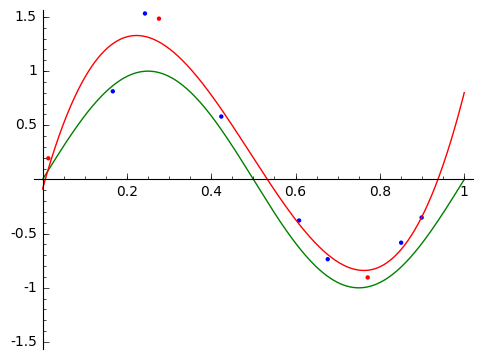

In [4]:
f_fit(x) = model.subs(fit)
fit_plt = plot(f_fit, [x, 0, 1],  rgbcolor='red')
(blue_plt + red_plt + sin_plt + fit_plt).show(xmin=0, xmax= 1, ymin=-1.5, ymax=1.5, figsize=5)

<html>
	<h3>データ数が足りない場合</h3>
	<p>
		モデルmodelでは、４個の未知数$w_0, w_1, w_2, w_3$を求めていますが、
		データの個数が４個よりも少ない場合には、どのようになるのか試してみましょう。
	</p>
	<p>
		１０個のデータのうち最初の３個（赤でプロットされた点）を使ってfind_fitを実行すると、
		以下のようにエラーとなってしまいます。
	</p>
</html>

In [5]:
# データ数が足りない場合には、エラーとなる
data = zip(X[:3], Y[:3]; print len(data)
fit = find_fit(data, model, solution_dict=True); print fit
f_fit(x) = model.subs(fit)
fit_plt = plot(f_fit, [x, 0, 1])
(blue_plt + red_plt + sin_plt + fit_plt).show(figsize=5)

SyntaxError: invalid syntax (<ipython-input-5-c397273c6a35>, line 2)

<html id="** 最小二乗法">
	<h2>最小二乗法</h2>
	<p>
		多項式によるフィッティング関数yを以下のように定義し、
$$
		y(x, w) = \sum^{M}_{j=0} w_j x^j
$$		
		各項の$x^n$を以下のように表すと、
$$
		\phi_j(x) = x^j
$$
		観測値YとXの関係を行列で表すと以下の式でもっと誤差の少ない重みwを求めることが最小二乗法の目的です。
$$
		Y \approx \Phi w
$$		
		ここで、$\Phi$の各要素は、以下の式で表されます。
$$
		\Phi_{nj} = \phi_j(x_n)
$$		
	</p>
	<p>
		<a href="http://www.amazon.co.jp/dp/4320017862/">これなら分かる最適化数学</a>によると、
		ムーア・ベンローズの一般逆行列$\Phi^{\dagger}$を使うと、重みwは次のように表すことができます。
$$
		w = \Phi^{\dagger} Y
$$		
		$\Phi^{\dagger}$は、データの個数n、未知数wの個数mとすると以下のようになります。
$$
		\Phi^{\dagger} = \left\{\begin{eqnarray}
			( \Phi^T \Phi )^{-1} \Phi^T & m > n \\
			\Phi^T (\Phi \Phi^T)^{-1}  & m < n
		\end{eqnarray}\right.
$$		
	</p>
	<p>
		ムーア・ベンローズの一般逆行列$\Phi^{\dagger}$を求めることで、データ数が足りない場合でも
		フィッティング関数を求めることができます。
	</p>
</html>

In [6]:
# 次数のセット
M = 3
# Φ関数定義
def _phi(x, j):
    return x^j

<html id="*** ムーア・ベンローズの一般逆行列">
	<h3>ムーア・ベンローズの一般逆行列</h3>
	<p>
		最初にデータ数が１０個の場合（n > m）の場合の、ムーア・ベンローズの一般逆行列$\Phi^{\dagger}$をSageを使って求めてみましょう。
	</p>	
	<p>
		$\Phi^{\dagger}$をほとんど定義と同じような形でSageで書き表すことができることに注目してください。
	</p>
</html>

In [7]:
# 計画行列Φ
Phi = matrix([[ _phi(x,j) for j in range(0, (M+1))] for x in X]);
Phi_t = Phi.transpose()
# ムーア・ベンローズの一般逆行列
Phi_dag = (Phi_t * Phi).inverse() * Phi_t;
# 平均の重み
Wml = Phi_dag * vector(Y)

<html id="*** 多項式yの定義">
	<h3>多項式yの定義</h3>
	<p>
		次に、求まった重みWmlを使って多項式y(x)を以下のように定義します。
	</p>
</html>

In [8]:
# 出力関数yの定義
y = lambda x : sum(Wml[i]*x^i for i in (0..M));

<html id="*** 多項式線形回帰の結果">
	<h3>多項式線形回帰の結果</h3>
	<p>
		データ数N=10, 未知数M=4の時の、多項式回帰の結果（赤）をサンプリング（青）とオリジナルの$sin(2 \pi x)$を合わせて
		プロットします。
	</p>
</html>

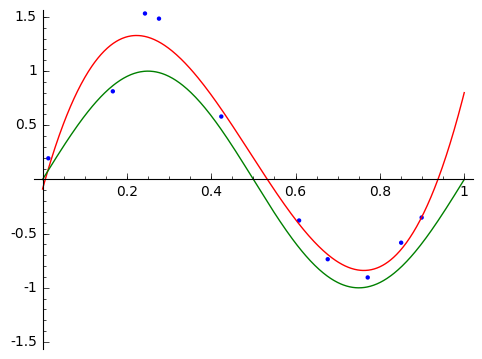

In [9]:
y_plt = plot(y, [x, 0, 1],  rgbcolor='red'); 
(y_plt + data_plt + sin_plt).show(xmin=0, xmax= 1, ymin=-1.5, ymax=1.5, figsize=5);

<html>
	<h2>データが少ない場合のムーア・ベンローズの一般逆行列</h2>
	<p>
		それでは、データ数N=3, 未知数M=4の時のムーア・ベンローズの一般逆行列$\Phi^{\dagger}$を計算し、
		その結果をプロットしてみましょう。
	</p>
</html>

In [10]:
# 計画行列Φ
Phi = matrix([[ _phi(x,j) for j in range(0, (M+1))] for x in X[:3]])
Phi_t = Phi.transpose()
# ムーア・ベンローズの一般逆行列
PhiPhit =  Phi*Phi_t
Phi_dag = Phi_t*PhiPhit.inverse()
show(Phi_dag)

[-0.06857088961206159 0.006065469790858202   1.0625015100048785]
[   5.046343862995325  -0.4593509019515363   -4.586688424516294]
[   -3.04991054592013     1.20292351698009   1.8455653392778717]
[ -4.3825896262470625   1.3805704197907072   3.0033593023655545]

In [11]:
# 平均の重み
Wml = Phi_dag * vector(Y[:3]); Wml.apply_map(lambda x : n(x))

(0.100463412348611, 7.01017348792055, -5.25466361108249, -7.16736911572035)

<html>
	<p>
		与えられた３点を通る3次曲線が求まっていることがわかりますが、3点の範囲以外では元のsin曲線からはかけ離れた形になっています。
	</p>
    <p>
      このように近似関数を使用する場合には、その適用範囲にも注意が必要です。
    </p>
</html>

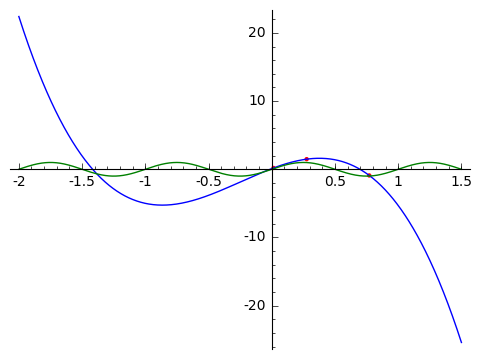

In [12]:
x = var('x')
y_plt = plot(y, [x, -2, 1.5],  rgbcolor='blue')
sin_plt = plot(sin(2*pi*x),[x, -2, 1.5], rgbcolor='green')
(y_plt + red_plt + sin_plt).show(figsize=5)

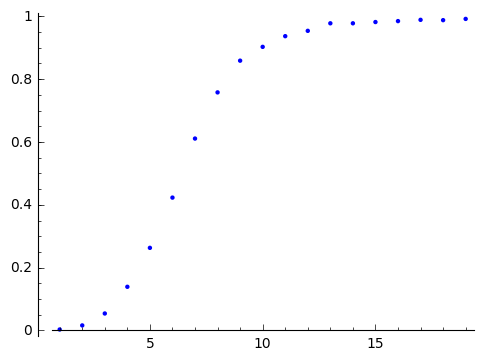

In [13]:
# 非線形回帰の例(ロジスティック関数)
X = range(1,20)
Y = [0.003,0.016,0.054,0.139,0.263, 0.423,0.611,0.758,0.859,
    0.903,0.937,0.954, 0.978,0.978,0.982,0.985,0.989,0.988,0.992]
data = zip(X, Y)
data_plt = list_plot(data)
data_plt.show(figsize=5);

In [14]:
(x, a, b, c) = var('x a b c')
model(x) = a/(1 + b*e^(c*x))
fit = find_fit(data, model, solution_dict=True); view(fit)

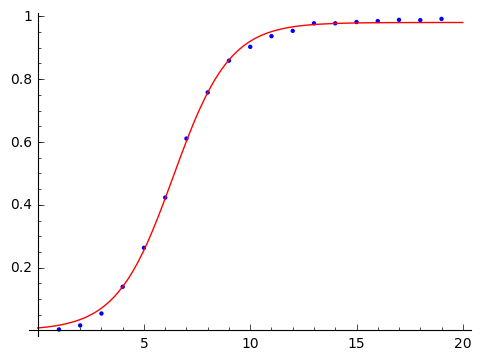

In [15]:
f_fit(x) = model.subs(fit)
fit_plt = plot(f_fit, [x, 0, 20], rgbcolor='red')
(data_plt + fit_plt).show(figsize=5)